# Evaluation of Graph Neural Network segment classifier

In [1]:
# Concurrency config
import os
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
import yaml

import numpy as np
import sklearn.metrics

import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt

In [3]:
# Local software setup
import sys
sys.path.append('..')

from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn

In [4]:
%matplotlib inline

In [5]:
def get_output_dir(config):
    return os.path.expandvars(config['experiment']['output_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['data']['input_dir'])

def load_config(config_file):
    with open(config_file) as f:
        return yaml.load(f)

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('model_type')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model

In [6]:
# Concurrency config
os.environ['OMP_NUM_THREADS'] = '4'

# Config path
config_file = '../configs/hello_graph.yaml'

In [7]:
!cat $config_file

data:
    name: hitgraphs
    n_train: 1000
    n_valid: 500
    batch_size: 2
    input_dir: /global/cscratch1/sd/xju/heptrkx/data/hitgraphs_001

experiment:
    name: gnn
    output_dir: /global/homes/x/xju/track/gnn/code/heptrkx-gnn-tracking/test_run_001

train:
    n_epochs: 20

model:
    model_type: 'gnn_segment_classifier'
    input_dim: 3
    n_iters: 6
    hidden_dim: 128
    loss_func: 'binary_cross_entropy'
    optimizer: 'Adam'
    learning_rate: 0.001


In [8]:
config = load_config(config_file)
summaries = load_summaries(config)

## Plot the Training loss and accuracy

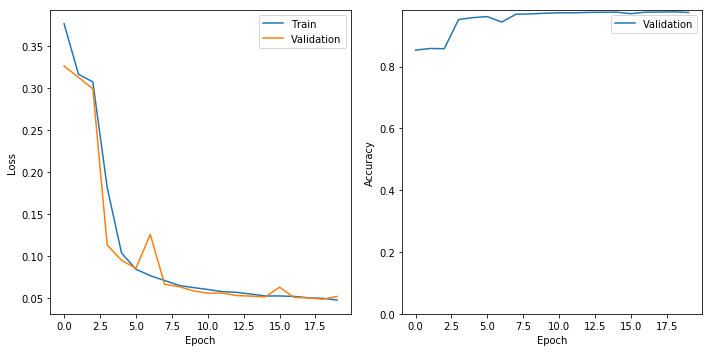

In [9]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

plt.tight_layout()

## Load the trained model

In [10]:
model = load_model(config, reload_epoch=18).eval()

loading model


## Load the test data set

In [11]:
n_test = 10

In [12]:
full_dataset = HitGraphDataset(get_input_dir(config))

# Take the test set from the back
test_indices = len(full_dataset) - 1 - torch.arange(n_test)
test_dataset = Subset(full_dataset, test_indices)

In [13]:
# Construct a data loaer
test_loader = DataLoader(test_dataset, collate_fn=collate_fn)

## Evaluate the model on the test dataset

In [14]:
%%time

with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in test_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)

CPU times: user 25.9 s, sys: 1.04 s, total: 26.9 s
Wall time: 6.94 s


In [15]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9722
Precision: 0.9443
Recall:    0.9484


In [16]:
# ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

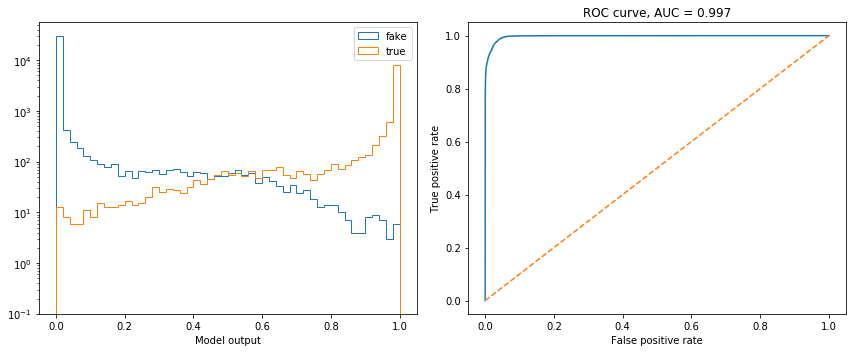

In [17]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='step', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

## Visualize predictions

In [18]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=True, figsize=(15, 7)):
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=figsize)
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$z$')
    ax1.set_xlabel('$\phi$')
    ax0.set_ylabel('$r$')
    ax1.set_ylabel('$r$')
    plt.tight_layout()

CPU times: user 18.6 s, sys: 162 ms, total: 18.7 s
Wall time: 18.7 s


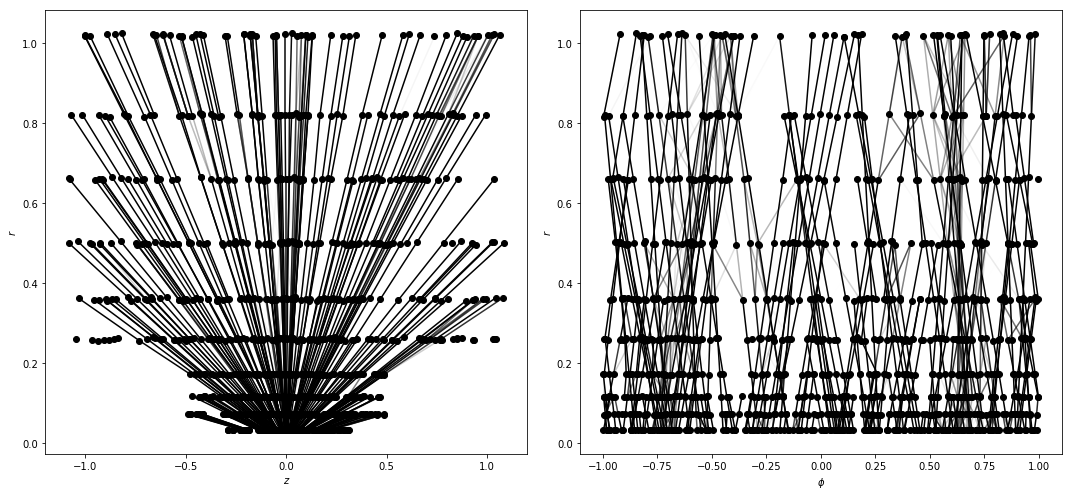

In [19]:
%%time

n_draw = 1
for i in range(n_draw):
    X, Ri, Ro, y = test_dataset[i]
    pred = test_outputs[i][0].numpy()
    draw_sample(X, Ri, Ro, pred, alpha_labels=True)

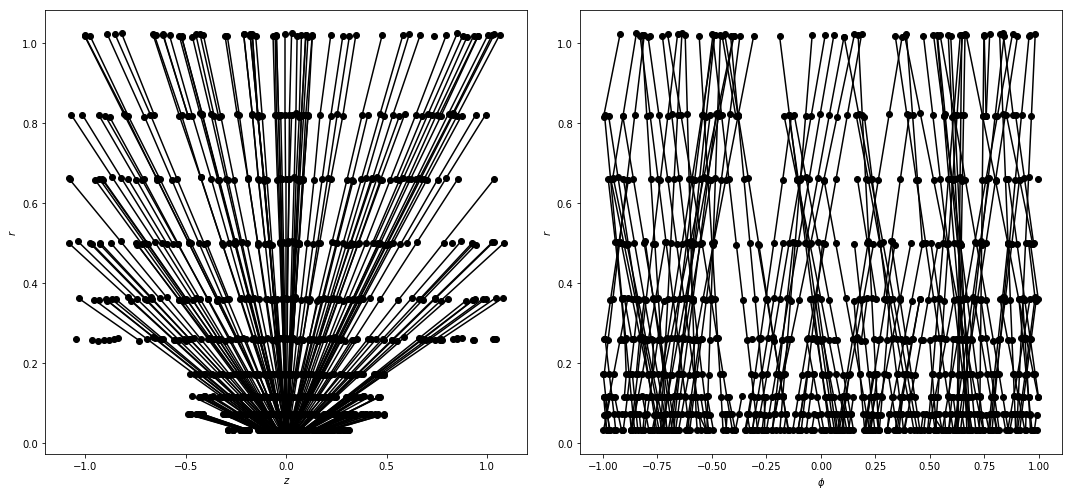

In [20]:
n_draw = 1
for i in range(n_draw):
    X, Ri, Ro, y = test_dataset[i]
    draw_sample(X, Ri, Ro, y, alpha_labels=True)

## Focus on one $\phi$ section in one event, try to compose a track out of hits and edges

In [90]:
iSec = 1

In [91]:
file_name = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_001/event000001000_g{:03d}.npz'.format(iSec)
id_name   = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_002/event000001000_g{:03d}_ID.npz'.format(iSec)

In [19]:
from datasets.graph import load_graph

In [92]:
G = load_graph(file_name)
f = np.load(id_name)

In [93]:
hit_ids = f['ID']
print(hit_ids.shape, G.X.shape, G.Ri.shape)

(1524,) (1524, 3) (1524, 4960)


In [94]:
n_hits = G.X.shape[0]
n_features = G.X.shape[1]
n_edges = G.Ri.shape[1]

In [95]:
batch_input = [torch.from_numpy(m[None]).float() for m in [G.X, G.Ri, G.Ro]]

In [96]:
with torch.no_grad():
    test_output = model(batch_input).flatten()

In [97]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [98]:
event_input_name = '/global/cscratch1/sd/xju/heptrkx/trackml_inputs/train_all/event000001000'
hits, cells, particles, truth = load_event(event_input_name)

In [99]:
weights = test_output.numpy()
print("precision: ", np.sum(weights*G.y)/G.y.nonzero()[0].shape[0])

precision:  0.9075574747721354


### match hit info

In [28]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [29]:
import pandas as pd

### Add layer info and other features in the DF

In [30]:
df_hits_used = pd.DataFrame(hit_ids, columns=['hit_id'])
df = df_hits_used.merge(hits, on='hit_id', how='inner')
df = df.merge(truth, on='hit_id', how='inner')
vlids = [(8,2), (8,4), (8,6), (8,8),
         (13,2), (13,4), (13,6), (13,8),
         (17,2), (17,4)
        ]
vlid_groups = df.groupby(['volume_id', 'layer_id'])
n_det_layers = len(vlids)
df = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer=i) for i in range(n_det_layers)])

r = np.sqrt(df.x**2 + df.y**2)
phi = np.arctan2(df.y, df.x)
df = df.assign(r=r, phi=phi)

In [31]:
df.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,layer,r,phi
0,19428,-25.136400,-19.796301,-26.657801,8,2,98,4505798650626048,-25.135099,-19.797800,-26.653900,-0.986383,-0.764421,-1.036230,0.000032,0,31.995815,-2.474486
10,19235,-28.876699,-14.167300,-2.571880,8,2,97,4505936089579520,-28.883499,-14.148000,-2.560950,-2.068640,-1.003450,-0.177512,0.000042,0,32.164829,-2.685482
20,19468,-15.647300,-27.908701,-46.263500,8,2,99,4506417125916672,-15.646800,-27.908899,-46.263401,-1.526070,-2.703920,-4.480110,0.000000,0,31.995836,-2.081787
22,21471,-31.225300,-5.950070,67.884102,8,2,113,4509165904986112,-31.225500,-5.949360,67.889099,-1.106630,-0.202198,2.405370,0.000025,0,31.787146,-2.953297
29,19528,-16.695299,-27.403700,-6.175290,8,2,99,4509509502369792,-16.699600,-27.401600,-6.175370,-0.568904,-0.952695,-0.211077,0.000027,0,32.088875,-2.117979


In [32]:
print("first  layer: " , df[df.layer == 0].shape[0])
print("second layer: " , df[df.layer == 1].shape[0])

first  layer:  261
second layer:  236


In [33]:
print("Last layer:           " , df[df.layer == n_det_layers-1].shape[0])
print("second-to-last layer: " , df[df.layer == n_det_layers-2].shape[0])

Last layer:            72
second-to-last layer:  96


In [81]:
# outer_layer = n_det_layers-1
# inner_layer = n_det_layers-2

outer_layer = 5
inner_layer = 4

In [82]:
outer_hits = df[df.layer == outer_layer][['hit_id']]
inner_hits = df[df.layer == inner_layer][['hit_id']]

In [83]:
df_hit_ids = pd.DataFrame(hit_ids, columns=['hit_id'])
df_hit_ids = df_hit_ids.assign(idx=df_hit_ids.index)
df_hit_ids.head()

,hit_id,idx
0,19428,0
1,28547,1
2,35183,2
3,41395,3
4,73437,4


In [84]:
outer_hits_idx = df_hit_ids.merge(outer_hits, on='hit_id', how='inner')['idx']
inner_hits_idx = df_hit_ids.merge(inner_hits, on='hit_id', how='inner')['idx']

In [89]:
print("# outer hits: {}".format(outer_hits_idx.shape[0]))
print("# inner hits: {}".format(inner_hits_idx.shape[0]))

# outer hits: 180
# inner hits: 196


### 1: best choice of each other

In [85]:
### from outer layers to inner layers
inner_cand_idx = []
selected_edge_idx = []
for idx in outer_hits_idx:
    hit_out = G.Ri[idx]
    weighted_outgoing = np.argsort(hit_out * weights)
    weight_idx = weighted_outgoing[-1]
    next_hit = G.Ro[:, weight_idx].nonzero()
    if next_hit[0].shape[0] > 0:
        next_hit_id = next_hit[0][0]
        edge_idx = weight_idx
    else:
        next_hit_id = -1
        edge_idx = -1
    inner_cand_idx.append(next_hit_id)
    selected_edge_idx.append(edge_idx)
# inner_cand_idx = np.array(inner_cand_idx)
res_inner_expolate = [(x,y) for x,y in zip(outer_hits_idx, inner_cand_idx)]


### from inner layers to outer layers
outer_cand_idx = []
for idx in inner_hits_idx:
    hit_out = G.Ro[idx]
    weighted_outgoing = np.argsort(hit_out * weights)
    weight_idx = weighted_outgoing[-1]
    next_hit = G.Ri[:, weight_idx].nonzero()
    if next_hit[0].shape[0] > 0:
        next_hit_id = next_hit[0][0]
    else:
        next_hit_id = -1
    outer_cand_idx.append(next_hit_id)

res_outer_expolate = [ (x,y) for x,y in zip(outer_cand_idx, inner_hits_idx)]

In [86]:
from collections import OrderedDict 

In [87]:
good_match = {}
to_be_det_idx = OrderedDict()
selected_edge_idx_final = []
for idx,ii in enumerate(res_inner_expolate):
    if ii in res_outer_expolate:
        good_match[ii[0]] = ii[1]
        selected_edge_idx_final.append(selected_edge_idx[idx])
#         res_outer_expolate.remove(ii)
    else:
        to_be_det_idx[ii[0]] = ii[1]

In [88]:
print("# of reciprocal choice: ", len(good_match.keys()))
print("# of to-be-determined:  ", len(to_be_det_idx.keys()))
print("# of good outer exp.:   ", len(res_outer_expolate))

# of reciprocal choice:  164
# of to-be-determined:   16
# of good outer exp.:    196


### 2: use inner expolation to determine those to-be-determined

In [42]:
values = np.array(list(to_be_det_idx.values()))
vals, count = np.unique(values, return_counts=True)
idx_vals_repeated = np.where(count > 1)[0]
repeated_out_hits = vals[idx_vals_repeated]
print("unique match: ", count.shape[0])
print("duplicated match: ", repeated_out_hits.shape[0])

unique match:  7
duplicated match:  1


In [44]:
used_hits = np.array(list(good_match.values()))

In [45]:
used_hits

array([   8,   18,  867,   66,   76,  105,  115,  129,  145,  168,  155,
        212,  306,  316,  341,  352,  366,  395,  465,  495,  543,  559,
        596,  654,  670,  707,  717,  727,  761,  773,  790,  830,  894,
        952,  981, 1009, 1019, 1029, 1044, 1054, 1064, 1084, 1101, 1128,
       1148, 1185,   57, 1317, 1345, 1381, 1400, 1403, 1408, 1428, 1461,
       1467, 1495, 1505, 1513, 1530, 1541, 1567, 1607, 1628])

In [46]:
inner_cand_idx2 = []
selected_edge_idx2 = []
for idx in to_be_det_idx.keys():
    hit_out = G.Ri[idx]
    weighted_outgoing = np.argsort(hit_out * weights)
    ii = -1
    next_hit_id = -1
    edge_idx = -1
    while True:
        weight_idx = weighted_outgoing[ii]
        next_hit = G.Ro[:, weight_idx].nonzero()
        if next_hit[0].shape[0] > 0:
            next_hit_id1 = next_hit[0][0]
#             print(idx,"next hit: ", next_hit_id1)
            if next_hit_id1 not in used_hits:
                next_hit_id = next_hit_id1
                edge_idx = weight_idx
                break
        ii -= 1
  
    inner_cand_idx2.append(next_hit_id)
    selected_edge_idx2.append(edge_idx)

### Get truth edges

In [47]:
### from outer layers to inner layers
inner_truth_idx = []
truth_edge_idx = []
for idx in outer_hits_idx:
    hit_out = G.Ri[idx]
    w_edges = hit_out * G.y
    
    next_hit_id = -1
    edge_idx = -1
    if w_edges.nonzero()[0].shape[0] > 0:
        weighted_outgoing = np.argsort(w_edges)
        weight_idx = weighted_outgoing[-1]
        next_hit = G.Ro[:, weight_idx].nonzero()
        if next_hit[0].shape[0] > 0:
            next_hit_id = next_hit[0][0]
            truth_edge_idx.append(weight_idx)

    inner_truth_idx.append(next_hit_id)

In [48]:
all_edges = selected_edge_idx2 + selected_edge_idx_final
vals, counts = np.unique(all_edges, return_counts=True)
n_true_pos_edge = int(np.sum(G.y[np.unique(all_edges)]))
n_true_edge = int(np.sum(G.y[truth_edge_idx]))
print("# of unique edges: ", vals.shape[0])
print("# of repeated    : ", vals[np.where(count > 1)].shape[0])
print("# of total edges:  ", len(all_edges))
print("# of positive:     ", n_true_pos_edge)
print("# of true edges:   ", n_true_edge)
print("precision:         ", n_true_pos_edge/n_true_edge)

# of unique edges:  71
# of repeated    :  1
# of total edges:   72
# of positive:      64
# of true edges:    68
precision:          0.9411764705882353


In [49]:
truth_match = {}
for x,y in zip(outer_hits_idx, inner_truth_idx):
    truth_match[x] = y

In [211]:
truth_pair = [(x,y) for x,y in zip(outer_hits_idx, inner_truth_idx)]

In [234]:
my_pair = []
for x,y in good_match.items():
    my_pair.append( (x, y))
    
my_pair  += [(x, y) for x,y in zip(to_be_det_idx.keys(), inner_cand_idx2)]

In [274]:
for i in my_pair:
    if i not in truth_pair:
        try:
            print(i, truth_match[i[0]], good_match[i[0]])
        except KeyError:
            print(i, truth_match[i[0]], "Not-good")

(37, 867) -1 867
(126, 129) 125 129
(183, 155) -1 155
(1242, 57) 1241 57
(130, 192) 129 Not-good
(156, 1620) 155 Not-good
(173, 1616) -1 Not-good
(868, 1616) 867 Not-good
(1392, 192) -1 Not-good


In [82]:
vals, count = np.unique(out_hits_idx, return_counts=True)
idx_vals_repeated = np.where(count > 1)[0]
repeated_out_hits = vals[idx_vals_repeated]
print("unique match: ", count.shape[0])
print("duplicated match: ", repeated_out_hits.shape[0])

unique match:  66
duplicated match:  5


build a dictionary for the one-to-one match

In [98]:
good_edges = {}
for x,y in zip(in_hits_idx, out_hits_idx):
    good_edges[x] = y

In [99]:
for key,value in good_edges.items():
    print(key, value)

9 8
19 18
37 867
67 66
77 76
106 105
116 115
126 129
130 129
146 145
156 155
169 168
173 1628
183 155
193 129
213 212
307 306
317 316
342 341
353 352
367 366
379 378
396 395
466 465
496 495
544 543
560 559
597 596
655 654
671 670
708 707
718 717
728 727
762 761
774 773
791 790
831 830
855 952
868 867
895 894
953 952
982 981
1010 1009
1020 1019
1030 1029
1045 1044
1055 1054
1065 1064
1085 1084
1102 1101
1129 1128
1149 1148
1186 1185
1242 57
1318 1317
1346 1345
1382 1381
1392 192
1401 1400
1404 1403
1409 1408
1429 1428
1462 1461
1468 1467
1496 1495
1506 1505
1514 1513
1531 1530
1542 1541
1568 1567
1608 1607
1629 1628


### 2: from repeated hits point-of-view, select incoming hits

In [83]:
favored_in_hits_idx = []
for idx in repeated_out_hits:
    hit_out = G.Ro[idx]
    weighted_outgoing = np.argsort(hit_out * weights)
    weight_idx = weighted_outgoing[-1]
    next_hit = G.Ri[:, weight_idx].nonzero()
    if next_hit[0].shape[0] > 0:
        next_hit_id = next_hit[0][0]
    else:
        next_hit_id = -1
    favored_in_hits_idx.append(next_hit_id)

favored_in_hits_idx = np.array(favored_in_hits_idx)

In [84]:
print(favored_in_hits_idx)

[ 126  183   37  953 1629]


In [85]:
print(repeated_out_hits)

[ 129  155  867  952 1628]


### 3: update the connections

In [96]:
# assign -1 to those repeated hits
for key,value in good_edges.items():
    if value in repeated_out_hits:
        good_edges[key] = -1
        
for idx,key in enumerate(favored_in_hits_idx):
    good_edges[key] = repeated_out_hits[idx]

In [97]:
for key,value in good_edges.items():
    print(key, value)

9 8
19 18
37 867
67 66
77 76
106 105
116 115
126 129
130 -1
146 145
156 -1
169 168
173 -1
183 155
193 -1
213 212
307 306
317 316
342 341
353 352
367 366
379 378
396 395
466 465
496 495
544 543
560 559
597 596
655 654
671 670
708 707
718 717
728 727
762 761
774 773
791 790
831 830
855 -1
868 -1
895 894
953 952
982 981
1010 1009
1020 1019
1030 1029
1045 1044
1055 1054
1065 1064
1085 1084
1102 1101
1129 1128
1149 1148
1186 1185
1242 57
1318 1317
1346 1345
1382 1381
1392 192
1401 1400
1404 1403
1409 1408
1429 1428
1462 1461
1468 1467
1496 1495
1506 1505
1514 1513
1531 1530
1542 1541
1568 1567
1608 1607
1629 1628


### 4. Try their second-to-largest weight.

In [137]:
%%time

xx = np.concatenate( (G.X, (G.X[:, 0] + np.abs(G.X[:, 2])).reshape(n_hits, 1) ), 1)
sorted_idx = np.argsort(xx[:, 3])

hits_in_tracks = []
hits_idx_in_tracks = []
all_tracks = []
all_idx_tracks = []

weights = test_output.numpy()
weight_cutoff = 0.8

for idx in sorted_idx:
    # Loop over all hits 
    # and save hits that are used in a track
    hit_id = hit_ids[idx]
    if hit_id not in hits_in_tracks:
        hits_in_tracks.append(hit_id)
        hits_idx_in_tracks.append(idx)
    else:
        continue

    a_track = [hit_id]
    a_idx_track = [idx]
    ilayer = 0
    while(True):
        ilayer += 1 ## which layer the hit is on...
        # for this hit index (idx),
        # find its outgoing hits that could form a track
        hit_out = G.Ro[idx]
        if hit_out.nonzero()[0].shape[0] < 1:
            break
            
        weighted_outgoing = np.argsort((hit_out * weights))
        ii = -1
        has_next_hit = False
        while abs(ii) < 12:
            weight_idx = weighted_outgoing[ii]
            next_hit = G.Ri[:, weight_idx].nonzero()
            if next_hit[0].shape[0] > 0:
                next_hit_id = next_hit[0][0]
                if next_hit_id != idx and next_hit_id not in hits_idx_in_tracks:
                    ## apply restrict weight cuts if the hit is on 4 layers (PIXELS)
                    if ilayer <= 4 and weights[weight_idx] < weight_cutoff:
                        # in this case, more dangling point in the pixel layers
                        break
#                     print(idx,"has next hit:", next_hit_id,"with weight:", weights[weight_idx], "in index of", ii)
                    hits_in_tracks.append(hit_ids[next_hit_id])
                    hits_idx_in_tracks.append(next_hit_id)
                    a_track       .append(hit_ids[next_hit_id])
                    a_idx_track   .append(next_hit_id)
                    idx = next_hit_id
                    has_next_hit = True
                    break
            ii -= 1

        if not has_next_hit:
            # no more out-going tracks
            break
            
    all_tracks    .append(a_track)
    all_idx_tracks.append(a_idx_track)

CPU times: user 260 ms, sys: 4 ms, total: 264 ms
Wall time: 262 ms


In [138]:
print(len(hits_in_tracks))
print(len(hits_idx_in_tracks))
n_used_hits = sum([len(track) for itrk, track in enumerate(all_idx_tracks)])
print("total used hits:", n_used_hits)

1676
1676
total used hits: 1676


In [139]:
total_tracks = len(all_idx_tracks)
print('total tracks:', total_tracks)

total tracks: 515


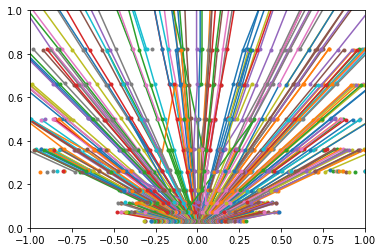

In [140]:
for trk_id in range(total_tracks):
    plt.plot(G.X[all_idx_tracks[trk_id], 2], G.X[all_idx_tracks[trk_id], 0], '.-')
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.savefig("fitted_tracks.pdf")

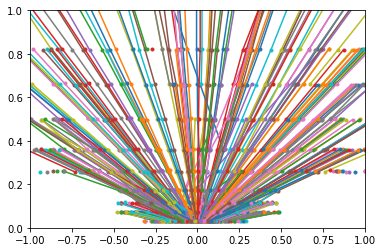

In [57]:
for trk_id in range(total_tracks):
    plt.plot(G.X[all_idx_tracks[trk_id], 2], G.X[all_idx_tracks[trk_id], 0], '.-')
plt.ylim(0, 1)
plt.xlim(-1, 1)
plt.savefig("fitted_tracks.pdf")

In [172]:
idx = 0
while(True):
    # for this hit index (idx),
    # find its outgoing hits that could form a track
    hit_out = G.Ro[idx]
    if hit_out.nonzero()[0].shape[0] < 1:
        break
    weighted_outgoing = np.argsort((hit_out * weights))
    ii = -1
    has_next_hit = False
    while abs(ii) < 12:
        weight_idx = weighted_outgoing[ii]
        next_hit = G.Ri[:, weight_idx].nonzero()
        if next_hit[0].shape[0] > 0:
            next_hit_id = next_hit[0][0]
            if next_hit_id != idx:
                print(idx,"has next hit:", next_hit_id,"with weight:", weights[weight_idx], "in index of", ii)
                idx = next_hit_id
                has_next_hit = True
                break
        ii -= 1

0 has next hit: 1 with weight: 0.9951929 in index of -1
1 has next hit: 2 with weight: 0.99601245 in index of -1
2 has next hit: 3 with weight: 0.9987332 in index of -1
3 has next hit: 4 with weight: 0.9980825 in index of -1
4 has next hit: 5 with weight: 0.996635 in index of -1
5 has next hit: 6 with weight: 0.93261933 in index of -1
6 has next hit: 7 with weight: 0.98705626 in index of -1
7 has next hit: 8 with weight: 0.992424 in index of -1
8 has next hit: 9 with weight: 0.986668 in index of -1


## Build a output for getting a score from track ML.

In [127]:
import pandas as pd

In [141]:
results = []
for itrk, track in enumerate(all_tracks):
    results += [(x, itrk) for x in track]
    
new_df = pd.DataFrame(results, columns=['hit_id', 'track_id'])
df_sub = hits[['hit_id']]
df_sub = df_sub.merge(new_df, on='hit_id', how='outer').fillna(total_tracks+1)
score_event(truth, df_sub)

0.01628763146202456

0.017003051033327166

In [136]:
0.017 / 0.024978677709898534

0.6805804613613815

using truth G.y as weight: 0.024978677709898534
using GNN weight: 0.016574876472760573
ratio = 0.66

### Evalation of first event results
  * total tracks:  1374
  * mean score: 0.06420239314690485

### from pairs to tracks

In [50]:
import pickle

In [51]:
pairs = pickle.load(open("../pairs.pkl", 'rb'))

In [52]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
g = nx.Graph()
for ilayer, pair in enumerate(pairs):
    for edges in pair:
        if(edges[1] == -1): continue
        g.add_edge(edges[0], edges[1], layer=ilayer)

In [54]:
n_hits_in_a_track = [len(c) for c in sorted(nx.connected_components(g), key=len, reverse=True)]

In [41]:
itrk = 0
for track in nx.connected_components(g):
    print(itrk, track)
    itrk += 1

0 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
1 {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
2 {1408, 1409, 256, 255, 1629, 1413, 257, 1034, 781, 909, 1176, 410, 923, 414, 542, 543, 544, 1279, 37, 1317, 935, 40, 1318, 173, 1581, 943, 1456, 182, 567, 1213, 1471, 1472, 194, 195, 1476, 581, 582, 1106, 1619, 217, 1626, 859, 1628, 861, 1627, 860, 864, 865, 866, 867, 868, 862, 863, 1512, 1513, 1514, 749, 494, 495, 880, 1649, 881, 496, 885, 506, 1405, 1406, 1407}
3 {64, 65, 66, 67, 58, 59, 60, 61, 62, 63}
4 {1376, 1377, 1378, 1379, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 1380, 1382, 1381, 1375}
5 {97, 98, 99, 100, 101, 102, 103, 104, 105, 106}
6 {1001, 1002, 1003, 110, 111, 112, 113, 114, 115, 116}
7 {128, 129, 130, 50, 51, 52, 53, 54, 55, 56, 57, 187, 188, 189, 190, 191, 192, 193, 1242, 1392, 117, 118, 119, 120, 121, 122, 123, 124, 126}
8 {137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 181}
9 {147, 148, 149, 150, 183, 152, 153, 154, 155, 156, 151}
10 {165, 166, 167, 168, 169, 1337, 1338, 1339, 1340, 1341,

In [56]:
itrk = 0
for track in nx.connected_components(g):
    #print(itrk, track)
    itrk += 1

In [57]:
list_pairs = []
for ilay,pair in enumerate(pairs):
    pair_dict = {}
    for edges in pair:
        pair_dict[edges[0]] = edges[1]
    list_pairs.append(pair_dict)

In [58]:
len(pairs)

9

In [59]:
id_name   = '/global/cscratch1/sd/xju/heptrkx/data/hitgraphs_002/event000001000_g000_ID.npz'

In [60]:
hit_ids = np.load(id_name)['ID']

In [61]:
hit_ids[0]

19428

### Form a track!

In [62]:
used_hits = []
all_tracks = []

for ilayer in range(n_det_layers-1):
    for hit,next_hit in list_pairs[ilayer].items():
        if hit in used_hits:
            continue
        if next_hit == -1:
            all_tracks.append([hit_ids[hit]])
            used_hits.append(hit)
            continue
            
        a_track = [hit_ids[hit], hit_ids[next_hit]]
        used_hits += [hit, next_hit]
        for ii in range(ilayer+1, 9, 1):
            try:
                nn_hit = list_pairs[ii][next_hit]
                if nn_hit == -1 or nn_hit in used_hits:
                    break
            except KeyError:
                break
            a_track.append(hit_ids[nn_hit])
            used_hits.append(nn_hit)
            next_hit = nn_hit
        all_tracks.append(a_track)

### Get a score

In [63]:
import pandas as pd
from trackml.dataset import load_event
from trackml.score import score_event


def get_score(all_tracks, hits, truth):
    total_tracks = len(all_tracks)
    print("total tracks: ", total_tracks)
    results = []
    for itrk, track in enumerate(all_tracks):
        results += [(x, itrk) for x in track]
        
    new_df = pd.DataFrame(results, columns=['hit_id', 'track_id'])
    new_df = new_df.drop_duplicates(subset='hit_id')
    
    df_sub = hits[['hit_id']]
    df_sub = df_sub.merge(new_df, on='hit_id', how='outer').fillna(total_tracks+1)
    
    
    matched = truth.merge(new_df, on='hit_id', how='inner')
    tot_truth_weight = np.sum(matched['weight'])
    ## remove the hits that belong to the same particle
    # but of that the total number is less than 50% of the hits of the particle
    particle_ids = np.unique(matched['particle_id'])
    for p_id in particle_ids:
        pID_match = matched[matched['particle_id'] == p_id]
        if pID_match.shape[0] < truth[truth['particle_id'] == p_id].shape[0]*0.5:
            tot_truth_weight -= np.sum(pID_match['weight'])
      
    print(df_sub.head())
    return [score_event(truth, df_sub), tot_truth_weight]

In [64]:
event_input_name = '/global/cscratch1/sd/xju/heptrkx/trackml_inputs/train_all/event000001000'
hits, cells, particles, truth = load_event(event_input_name)

In [65]:
aa = get_score(all_tracks, hits, truth)
print(aa)
print(aa[0]/aa[1])

total tracks:  346
   hit_id  track_id
0       1     347.0
1       2     347.0
2       3     347.0
3       4     347.0
4       5     347.0
[0.017781145164740456, 0.028160125]
0.6314299085640154


In [78]:
idx = 4959
G.Ro[:, idx].nonzero(), G.Ri[:, idx].nonzero()

((array([1111]),), (array([1112]),))

In [70]:
G.y[5495]

1.0

In [72]:
w_edges = G.Ri[282] * weights

In [80]:
G.Ro[:, 4959].nonzero()

(array([1111]),)